# Моделирование и идентификация линейной системы

## Эквивалентность моделей вход-выход, моделей в пространстве состояний и авторегрессионных моделей ВР 

In [1]:
from datetime import datetime
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from scipy.signal import dlti, dlsim, unit_impulse
from scipy.linalg import norm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math
import statsmodels.api as sm

from linear_dynamics import LinearDynamicalSystem as LDS
np.set_printoptions(precision=2)
RS = RandomState(MT19937(SeedSequence(int(datetime.now().timestamp()*1e5))))

In [2]:
def bmatrix(a: np.ndarray, name: str) -> str:
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(np.round(a, 3)).replace('[', '').replace(']', '').splitlines()
    rv = [name + r' = \begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

def plot_signal(sig: np.ndarray, filtered: np.array) -> None:
    """Visualize system response

    :sig: numpy array, input signal
    :filtered: numpy array, system response
    """
    fig, (ax_orig, ax_filt) = plt.subplots(2, 1, sharex=True)
    ax_orig.plot(sig)
    ax_orig.set_title('Original pulse')
    ax_orig.margins(0, 0.1)
    ax_filt.plot(filtered)
    ax_filt.set_title('Filtered signal')
    ax_filt.margins(0, 0.1)
    fig.tight_layout()
    plt.show()

## Задаем параметры жордановой клетки и количества наблюдений 

In [3]:
N_REAL = 4
N_COMPLEX = 1
T_OBS = 150

In [4]:
lds = LDS(N_REAL, N_COMPLEX)
sig = unit_impulse(T_OBS)

In [5]:
display(Math(bmatrix(np.array(lds.f_s), r'f^s')))
display(Math(bmatrix(np.array(lds.f_c), r'f^c')))
display(Math(bmatrix(np.array(lds.ro), r'\rho')))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Запуск симуляции 

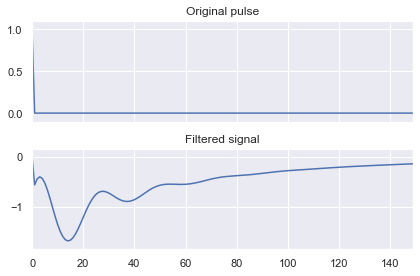

In [6]:
%matplotlib inline
sns.set()
plot_signal(sig, lds.simulate(T_OBS, sig))

## Переход к пространству состояний 

In [7]:
system = dlti(*lds.get_statespace(), dt=1)

C:\Users\andro\Documents\Python Scripts\linear_dynamics\linear_dynamics.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  A[:, -1] = np.array(ai[::-1]).T


In [8]:
_, y, _ = dlsim(system, sig)

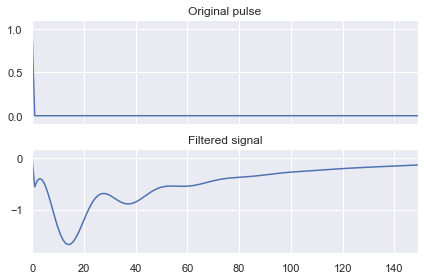

In [9]:
%matplotlib inline
plot_signal(sig, y.T.ravel())

## Переход к модели авторегрессии

In [10]:
arma_process = sm.tsa.ArmaProcess(*lds.get_arma())

C:\Users\andro\Documents\Python Scripts\linear_dynamics\linear_dynamics.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  A[:, -1] = np.array(ai[::-1]).T


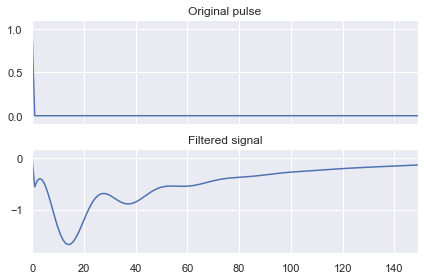

In [11]:
%matplotlib inline
plot_signal(sig, arma_process.impulse_response(T_OBS))

## Идентификация системы

### Выбор входного сигнала

#### Входной сигнал будет представлять собой прямоугольные сигналы единой длины c различными интервалами релаксации и напряжения

In [57]:
def construct_signal(l: int, u0: float = 1.) -> np.array:
    K = np.random.choice(np.arange(1, np.floor(l/4).astype(int)))
    return np.array([1.]*K+[0.]*l)*u0

L = 50
sig = np.concatenate([construct_signal(L, 0.9) for i in range(250)])

In [79]:
_, y, _ =dlsim(system, sig)
y += 1e-5*np.random.uniform(size=(len(sig), 1))

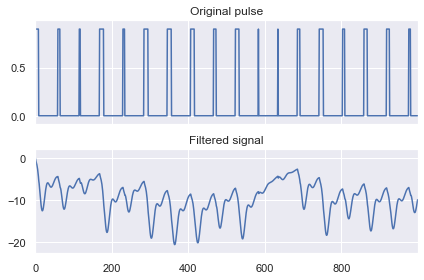

In [80]:
%matplotlib inline
plot_signal(sig[:1000], y.T.ravel()[:1000])

In [60]:
from scipy.linalg import svd, block_diag, solve, inv, pinv
from numba import njit

### Строим матрицу наблюдений при интервалах релаксации и находим оценку размерности системы через сингулярное разложение 

In [61]:
Yhat = y.T.ravel()[sig==0.].reshape(-1, L).T[::-1]

In [64]:
def estimate_dimensionality(Yhat: np.ndarray, eps: float = 1e-4) -> int:
    U, sigma, V = svd(Yhat.T)
    sigma = np.vstack(
        (block_diag(*sigma), 
         np.zeros((U.shape[0]-sigma.shape[0], sigma.shape[0])))
    )
    n = 0
    for dim in range(1, len(sigma)):
        Yl = np.dot(np.dot(U[:, dim:], sigma[dim:, dim:]), V[dim:, :]).T
        if norm(Yl, ord=np.inf) <= eps:
            n=dim
            break
    return n
        
N_estimated = estimate_dimensionality(Yhat, eps=0.001)

def solve_moore_penrose(u_t: np.ndarray, y_t: np.ndarray, lags: int = N_estimated):
    a = []
    y_rhs = y_t[lags:2*lags]
    for i in range(lags):
        a.append(np.append(y_t[i:lags+i][::-1], u_t[i:lags+i][::-1])[np.newaxis, ...])
    a = np.concatenate(a, axis=0)
    ab = pinv(a)@y_rhs
    a, b_estimated = ab[:lags], ab[lags:]
    a_estimated = np.eye(len(a), k=-1)
    a_estimated[:, -1] = np.array(a[::-1]).T
    return a_estimated, b_estimated[::-1].reshape(-1, 1)
    
def solve_svd(Yhat: np.ndarray, k: int = N_estimated, y_rhs: np.ndarray = None):
    U, sigma, V = svd(Yhat.T[:, -k:])
    y_rhs = Yhat.T[:, L-k-2] if y_rhs is None else y_rhs
    sigma = block_diag(*sigma)
    solution = np.dot(np.dot(np.dot(V.T, inv(sigma)), U[:, :k].T), y_rhs)
    return solution
    

In [73]:
display(Math(r'$ N_{approx} = %s $' % N_estimated))

<IPython.core.display.Math object>

### Как видно, установленный порядок системы не слишком отличается от действительного порядка системы

### Находим параметры динамической системы, решая переопределенную СЛАУ

In [66]:
a_estimated, b_estimated = solve_moore_penrose(sig, y.T.ravel(), N_estimated)

In [68]:
system_reconstructed = dlti(a_estimated, b_estimated, np.array([0.]*(N_estimated-1)+[1.]).reshape(1, -1), [[0,]], dt=1)

In [77]:
display(Math(bmatrix(system_reconstructed.A, r'A_{approx}')))
display(Math(bmatrix(system.A, r'A_{true}')))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Исследуем отклик идентифицированной системы на входной сигнал и сравним его с откликом исходной системы

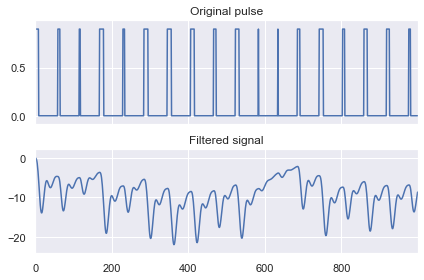

In [78]:
_, y_rec, _ = dlsim(system_reconstructed, sig)

%matplotlib inline
plot_signal(sig[:1000], y_rec.T.ravel()[:1000])

In [83]:
display(Math(r'$ || \epsilon_{1,2} ||_\infty = %s $' % str(norm(y_rec.T.ravel()-y.T.ravel(), ord=np.inf))))

<IPython.core.display.Math object>

## Вывод: исходная система была хорошо идентифицируема